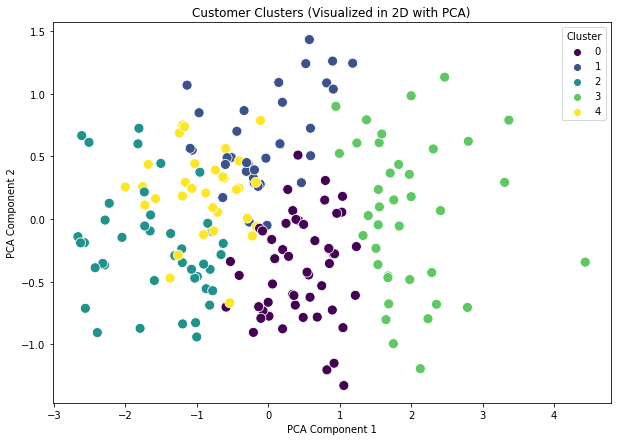

Shruti_Pande_Clustering.pdf has been generated.


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF

# Load data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")


customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",         # Total spending
    "ProductID": "nunique",      # Number of unique products purchased
    "Category": lambda x: x.mode()[0],  # Most common product category
    "Region": lambda x: x.mode()[0],    # Most common region
}).reset_index()

# Identify numerical and categorical columns
numerical_cols = ['TotalValue', 'ProductID']
categorical_cols = ['Category', 'Region']

# Preprocessing: One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Transform features
transformed_features = preprocessor.fit_transform(customer_features)

# Perform clustering using KMeans
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(transformed_features)

# Add cluster labels to the original data
customer_features['Cluster'] = clusters

# Calculate clustering metrics
db_index = davies_bouldin_score(transformed_features, clusters)
silhouette_avg = silhouette_score(transformed_features, clusters)

# Visualize clusters using a 2D plot 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(transformed_features)
reduced_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
reduced_df['Cluster'] = clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_df, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=100)
plt.title("Customer Clusters (Visualized in 2D with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.savefig("cluster_visualization.png")  # Save the plot as an image
plt.show()

# Generate PDF report
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Clustering Analysis Report', border=False, ln=True, align='C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', align='C')

pdf = PDFReport()
pdf.add_page()

# Add clustering summary
pdf.set_font('Arial', '', 12)
pdf.cell(0, 10, f'Number of clusters formed: {num_clusters}', ln=True)
pdf.cell(0, 10, f'Davies-Bouldin Index (DB Index): {db_index:.2f}', ln=True)
pdf.cell(0, 10, f'Silhouette Score: {silhouette_avg:.2f}', ln=True)

# Add the visualization
pdf.ln(10)
pdf.cell(0, 10, 'Cluster Visualization:', ln=True)
pdf.image('cluster_visualization.png', x=10, y=None, w=190)

# Save the PDF
pdf.output("Shruti_Pande_Clustering.pdf")
print("Shruti_Pande_Clustering.pdf has been generated.")
